<h3>Report</h3>

In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
import pickle

<h3>Loading Models</h3>

In [3]:
from core.network import *
from core.trainer import *

In [4]:
device = torch.device("cuda:0")
dir_load = '../models/'

In [5]:
net = LSTM(1, 98, 9, num_layers=3, device=device).to(device)
model = LSTMTrainer(net, device=device)
model2 = LSTMTrainer(net, device=device)

<h3>Dataloading for Eval</h3>

In [6]:
ligands = ["TNF", "R84", "PIC", "P3K", "FLA", "CpG", "FSL", "LPS", "UST"]
polarization = ["", "ib", "ig", "i0", "i3", "i4"]
replicas, size = 2, 1288

In [7]:
from core.getdata import *
from core.dataset import * 
from core.dataset2 import *

In [8]:
data = DatasetPolar(ligands, polarization, replicas, size)
data2 = DatasetNaive(ligands, replicas, size)

In [9]:
from torch.utils.data import Dataset
from torchvision import datasets

In [10]:
print(len(data), 0.25 * len(data)) # we'll test our data on 25% of the dataset
print(len(data2), 0.25 * len(data2))

69552 17388.0
11592 2898.0


In [11]:
_, datatest = torch.utils.data.random_split(data, [69552 - 17388 - 24, 17388 + 24])
_, dataset2 = torch.utils.data.random_split(data2, [11592 - 2880, 2880]) # 302
testloader = torch.utils.data.DataLoader(datatest, batch_size=32, shuffle=True)
testloader2 = torch.utils.data.DataLoader(dataset2, batch_size=16, shuffle=True)

<h3>Evaluation Loop</h3>

In [12]:
model.load(dir_load + 'lstm1.pth') # polarized

In [13]:
polarization_true, polarization_pred, polarized_prob = np.empty([32,]).T, np.empty([32,]).T, np.empty([32,]).T

In [14]:
for x, y in testloader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    polarization_true = np.hstack([polarization_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    # import pdb; pdb.set_trace()
    y_prob = np.amax(y_pred, axis=1)
    polarized_prob = np.hstack([polarized_prob, y_prob.T])
    y_pred = np.argmax(y_pred, axis=1)
    polarization_pred = np.hstack([polarization_pred, y_pred.T])
    #y_true = (32, ); y_pred = (32, ); y_prob = (32, 9)

In [15]:
model2.load(dir_load + 'lstm.pth') # naive

In [16]:
naive_true, naive_pred, naive_prob = np.empty([16,]).T, np.empty([16,]).T, np.empty([16,]).T

In [17]:
for x2, y2 in testloader2:
    x2, y2 = x2.to(device), y2.to(device)
    y_true = y2.detach().cpu().numpy()
    naive_true = np.hstack([naive_true, y_true.T])
    y_pred = model2.network(x2)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    y_prob = np.amax(y_pred, axis=1)
    naive_prob = np.hstack([naive_prob, y_prob.T])
    y_pred = np.argmax(y_pred, axis=1)
    #import pdb; pdb.set_trace()
    naive_pred = np.hstack([naive_pred, y_pred.T])
    #y_true = (16, ); y_pred = (16, ); y_prob = (16, 9)

In [18]:
polarization_true, polarization_pred = polarization_true[32:], polarization_pred[32:]
naive_true, naive_pred = naive_true[16:], naive_pred[16:]
polarized_prob, naive_prob = polarized_prob[32:], naive_prob[16:]
print(naive_true.shape, naive_pred.shape, polarization_true.shape, polarization_pred.shape, polarized_prob.shape, naive_prob.shape)

(2880,) (2880,) (17412,) (17412,) (17412,) (2880,)


In [19]:
naive_prob[0]

0.906500518321991

In [20]:
comparison = np.vstack([polarization_true, polarization_pred]).T
comparison2 = np.vstack([naive_true, naive_pred]).T

comp_prob_polar = np.vstack([polarized_prob, polarization_true]).T
comp_prob_naive = np.vstack([naive_prob, np.ones((2880,))]).T

wait = np.vstack([polarized_prob[:2880], naive_prob]).T

In [21]:
df, df2, df3, df4 = pd.DataFrame(comparison), pd.DataFrame(comparison2), pd.DataFrame(comp_prob_polar), pd.DataFrame(comp_prob_naive)
df5 = pd.DataFrame(wait)

In [22]:
print(df3)

              0    1
0      0.997823  4.0
1      0.980546  4.0
2      0.937413  1.0
3      0.999479  2.0
4      0.999630  7.0
...         ...  ...
17407  0.856710  7.0
17408  0.997073  2.0
17409  0.987856  0.0
17410  0.742137  1.0
17411  0.875265  5.0

[17412 rows x 2 columns]


In [23]:
print(df)

         0    1
0      4.0  4.0
1      4.0  4.0
2      1.0  1.0
3      2.0  2.0
4      7.0  7.0
...    ...  ...
17407  7.0  7.0
17408  2.0  2.0
17409  0.0  0.0
17410  1.0  1.0
17411  5.0  5.0

[17412 rows x 2 columns]


In [24]:
print(df2)

        0    1
0     6.0  6.0
1     7.0  7.0
2     5.0  5.0
3     1.0  1.0
4     1.0  1.0
...   ...  ...
2875  7.0  7.0
2876  6.0  6.0
2877  0.0  0.0
2878  7.0  7.0
2879  7.0  7.0

[2880 rows x 2 columns]


<h3>Naive/Polarized Metrics</h3>

In [25]:
# ACCURACY
print(f' Naive Accuracy: {sum(df2[0] == df2[1])/2880} \n Polarized Accuracy: {sum(df[0] == df[1])/17412}')

 Naive Accuracy: 0.9618055555555556 
 Polarized Accuracy: 0.9175855731679302


In [26]:
naive_report = sklearn.metrics.classification_report(df2[0], df2[1], target_names=ligands, output_dict=True)
naive_rep = pd.DataFrame(naive_report).transpose()

polarized_report = sklearn.metrics.classification_report(df[0], df[1], target_names=ligands, output_dict=True)
polarized_rep = pd.DataFrame(polarized_report).transpose()

In [27]:
print(naive_rep)

              precision    recall  f1-score      support
TNF            0.978056  0.987342  0.982677   316.000000
R84            0.986711  0.868421  0.923795   342.000000
PIC            0.994065  0.988201  0.991124   339.000000
P3K            0.934247  0.985549  0.959212   346.000000
FLA            0.957317  0.957317  0.957317   328.000000
CpG            0.954545  0.947917  0.951220   288.000000
FSL            0.905724  0.930796  0.918089   289.000000
LPS            0.964706  0.990937  0.977645   331.000000
UST            0.980456  1.000000  0.990132   301.000000
accuracy       0.961806  0.961806  0.961806     0.961806
macro avg      0.961759  0.961831  0.961246  2880.000000
weighted avg   0.962450  0.961806  0.961546  2880.000000


In [28]:
print(polarized_rep)

              precision    recall  f1-score       support
TNF            0.932203  0.895013  0.913230   1905.000000
R84            0.938067  0.912727  0.925224   1925.000000
PIC            0.944870  0.960062  0.952405   1928.000000
P3K            0.903895  0.912666  0.908259   1958.000000
FLA            0.867230  0.901758  0.884157   1934.000000
CpG            0.888719  0.893279  0.890993   1949.000000
FSL            0.880685  0.894685  0.887629   2013.000000
LPS            0.911653  0.889476  0.900428   1891.000000
UST            0.997388  1.000000  0.998692   1909.000000
accuracy       0.917586  0.917586  0.917586      0.917586
macro avg      0.918301  0.917741  0.917891  17412.000000
weighted avg   0.917945  0.917586  0.917636  17412.000000


In [29]:
polarizedf1, naivef1, totalf1 = polarized_rep[:9], naive_rep[:9], pd.concat([polarized_rep[:9], naive_rep[:9]], axis=1)

<AxesSubplot:>

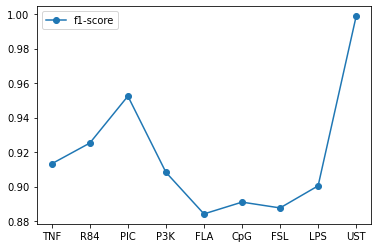

In [30]:
polarizedf1.plot(y='f1-score', style='o-')

<AxesSubplot:>

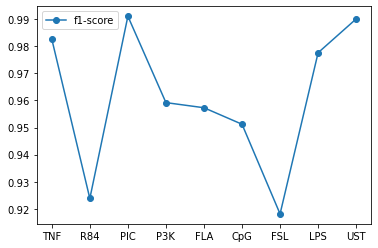

In [31]:
naivef1.plot(y='f1-score', style='o-')

<AxesSubplot:>

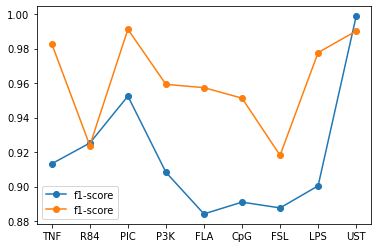

In [32]:
totalf1.plot(y='f1-score', style='o-') 

In [33]:
polarized_confusion = sklearn.metrics.confusion_matrix(df[0], df[1])
pccm = sklearn.metrics.ConfusionMatrixDisplay(polarized_confusion)

naive_confusion = sklearn.metrics.confusion_matrix(df2[0], df2[1])
nccm = sklearn.metrics.ConfusionMatrixDisplay(naive_confusion)

#polarized_fraction = sklearn.metrics.confusion_matrix(df3[0], df3[1])
#pcfm = sklearn.metrics.ConfusionMatrixDisplay(polarized_fraction)

#naive_fraction = sklearn.metrics.confusion_matrix(df4[0], df4[1])
#ncfm = sklearn.metrics.ConfusionMatrixDisplay(naive_fraction)

#test = sklearn.metrics.confusion_matrix(df5[0], df5[1])
#kek = sklearn.metrics.ConfusionMatrixDisplay(test)

In [34]:
print(df5)

             0         1
0     0.997823  0.906501
1     0.980546  0.999618
2     0.937413  0.998068
3     0.999479  0.999916
4     0.999630  0.999958
...        ...       ...
2875  0.999959  0.996864
2876  1.000000  0.991827
2877  0.622355  0.967994
2878  0.999152  0.995018
2879  0.999803  0.999870

[2880 rows x 2 columns]


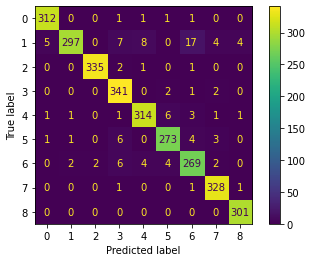

In [35]:
nccm.plot()

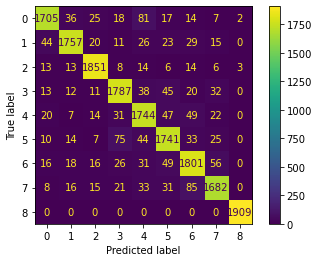

In [36]:
pccm.plot()

In [37]:
# pcfm.plot()

<h3>Polarization State Analysis</h3>

In [38]:
ligands = ["TNF", "R84", "PIC", "P3K", "FLA", "CpG", "FSL", "LPS", "UST"]
polarization = ["", "ib", "ig", "i0", "i3", "i4"]
replicas, size = 2, 1288

In [39]:
unpolarized_data = DatasetPolar(ligands, [""], replicas, size)
ib = DatasetPolar(ligands, ["ib"], replicas, size)
ig = DatasetPolar(ligands, ["ig"], replicas, size)
i0 = DatasetPolar(ligands, ["i0"], replicas, size)
i3 = DatasetPolar(ligands, ["i3"], replicas, size)
i4 = DatasetPolar(ligands, ["i4"], replicas, size)

In [40]:
print(len(unpolarized_data) + len(ib) + len(ig) + len(i0) + len(i3) + len(i4))
print(len(i4))

69552
11592


In [41]:
_, unpolarizedtest = torch.utils.data.random_split(unpolarized_data, [11592 - 3200, 3200])
_, ibtest = torch.utils.data.random_split(unpolarized_data, [11592 - 3200, 3200])
_, igtest = torch.utils.data.random_split(unpolarized_data, [11592 - 3200, 3200])
_, i0test = torch.utils.data.random_split(unpolarized_data, [11592 - 3200, 3200])
_, i3test = torch.utils.data.random_split(unpolarized_data, [11592 - 3200, 3200])
_, i4test = torch.utils.data.random_split(unpolarized_data, [11592 - 3200, 3200])

uploader = torch.utils.data.DataLoader(unpolarizedtest, batch_size=32, shuffle=True)
ibloader = torch.utils.data.DataLoader(ibtest, batch_size=32, shuffle=True)
igloader = torch.utils.data.DataLoader(igtest, batch_size=32, shuffle=True)
i0loader = torch.utils.data.DataLoader(i0test, batch_size=32, shuffle=True)
i3loader = torch.utils.data.DataLoader(i3test, batch_size=32, shuffle=True)
i4loader = torch.utils.data.DataLoader(i4test, batch_size=32, shuffle=True)

<h3>Evaluation Loop</h3>

In [42]:
model.load(dir_load + 'lstm1.pth') # polarized

In [43]:
up_true, up_pred = np.empty([32,]), np.empty([32,])
ib_true, ib_pred = np.empty([32,]), np.empty([32,])
ig_true, ig_pred = np.empty([32,]), np.empty([32,])
i0_true, i0_pred = np.empty([32,]), np.empty([32,])
i3_true, i3_pred = np.empty([32,]), np.empty([32,])
i4_true, i4_pred = np.empty([32,]), np.empty([32,])

In [44]:
for x, y in uploader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    up_true = np.hstack([up_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    y_pred = np.argmax(y_pred, axis=1)
    up_pred = np.hstack([up_pred, y_pred.T])
    
for x, y in ibloader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    ib_true = np.hstack([up_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    y_pred = np.argmax(y_pred, axis=1)
    ib_pred = np.hstack([up_pred, y_pred.T])
    
for x, y in igloader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    ig_true = np.hstack([ig_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    y_pred = np.argmax(y_pred, axis=1)
    ig_pred = np.hstack([ig_pred, y_pred.T])
    
for x, y in i0loader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    i0_true = np.hstack([i0_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    y_pred = np.argmax(y_pred, axis=1)
    i0_pred = np.hstack([i0_pred, y_pred.T])
    
for x, y in i3loader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    i3_true = np.hstack([i3_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    y_pred = np.argmax(y_pred, axis=1)
    i3_pred = np.hstack([i3_pred, y_pred.T])
    
for x, y in igloader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    i4_true = np.hstack([i4_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    y_pred = np.argmax(y_pred, axis=1)
    i4_pred = np.hstack([i4_pred, y_pred.T])

In [45]:
up_true, up_pred = up_true[32:], up_pred[32:]
ib_true, ib_pred = ib_true[32:], ib_pred[32:]
ig_true, ig_pred = up_true[32:], up_pred[32:]
i0_true, i0_pred = ib_true[32:], ib_pred[32:]
i3_true, i3_pred = up_true[32:], up_pred[32:]
i4_true, i4_pred = ib_true[32:], ib_pred[32:]

In [46]:
up_df = np.vstack([up_true, up_pred]).T
up_df = pd.DataFrame(up_df)

ib_df = np.vstack([ib_true, ib_pred]).T
ib_df = pd.DataFrame(ib_df)

ig_df = np.vstack([ig_true, ig_pred]).T
ig_df = pd.DataFrame(ig_df)

i0_df = np.vstack([i0_true, i0_pred]).T
i0_df = pd.DataFrame(i0_df)

i3_df = np.vstack([i3_true, i3_pred]).T
i3_df = pd.DataFrame(i3_df)

i4_df = np.vstack([i4_true, i4_pred]).T
i4_df = pd.DataFrame(i4_df)

In [47]:
print(up_df)

        0    1
0     3.0  3.0
1     8.0  8.0
2     1.0  1.0
3     7.0  7.0
4     4.0  4.0
...   ...  ...
3195  2.0  2.0
3196  7.0  7.0
3197  8.0  8.0
3198  5.0  5.0
3199  1.0  1.0

[3200 rows x 2 columns]


In [48]:
print(f' Accuracy: {sum(up_df[0] == up_df[1])/3200}')

 Accuracy: 0.8875


In [49]:
print(ib_df)

        0    1
0     3.0  3.0
1     8.0  8.0
2     1.0  1.0
3     7.0  7.0
4     4.0  4.0
...   ...  ...
3227  5.0  5.0
3228  7.0  7.0
3229  1.0  1.0
3230  5.0  5.0
3231  0.0  1.0

[3232 rows x 2 columns]


In [52]:
print(f' Accuracy: {sum(ib_df[0] == ib_df[1])/3232}')

 Accuracy: 0.8879950495049505


In [51]:
print(ig_df)

        0    1
0     5.0  5.0
1     6.0  6.0
2     6.0  6.0
3     5.0  5.0
4     6.0  4.0
...   ...  ...
3163  2.0  2.0
3164  7.0  7.0
3165  8.0  8.0
3166  5.0  5.0
3167  1.0  1.0

[3168 rows x 2 columns]


In [54]:
print(f' Accuracy: {sum(ig_df[0] == ig_df[1])/3168}')

 Accuracy: 0.8873106060606061


In [55]:
print(i0_df)

        0    1
0     5.0  5.0
1     6.0  6.0
2     6.0  6.0
3     5.0  5.0
4     6.0  4.0
...   ...  ...
3195  5.0  5.0
3196  7.0  7.0
3197  1.0  1.0
3198  5.0  5.0
3199  0.0  1.0

[3200 rows x 2 columns]


In [56]:
print(f' Accuracy: {sum(i0_df[0] == i0_df[1])/3200}')

 Accuracy: 0.8878125


In [57]:
print(i3_df)

        0    1
0     5.0  5.0
1     6.0  6.0
2     6.0  6.0
3     5.0  5.0
4     6.0  4.0
...   ...  ...
3163  2.0  2.0
3164  7.0  7.0
3165  8.0  8.0
3166  5.0  5.0
3167  1.0  1.0

[3168 rows x 2 columns]


In [58]:
print(f' Accuracy: {sum(i3_df[0] == i3_df[1])/3168}')

 Accuracy: 0.8873106060606061


In [59]:
print(i4_df)

        0    1
0     5.0  5.0
1     6.0  6.0
2     6.0  6.0
3     5.0  5.0
4     6.0  4.0
...   ...  ...
3195  5.0  5.0
3196  7.0  7.0
3197  1.0  1.0
3198  5.0  5.0
3199  0.0  1.0

[3200 rows x 2 columns]


In [61]:
print(f' Accuracy: {sum(i4_df[0] == i4_df[1])/3200}')

 Accuracy: 0.8878125
